# Import necessary libraries
`torchinfo` can display the model architecture  
`torcheval` can conveniently calculate some evaluation metrics  
`transformers`, `timm` provide a wide range of models and tools  

In [1]:
%pip install torchinfo torcheval transformers timm
%pip install --upgrade seaborn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 8.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
## Deep-Leaning framework
import torch                            
import torch.nn as nn                   
import torchvision                      
import torchvision.transforms as tf     
from torch.utils.data import Dataset    
from torch.utils.data import DataLoader
from torcheval.metrics import MulticlassAUPRC, MulticlassAccuracy 
import timm                 

## Auxiliary libraries related to deep learning
from torchinfo import summary 
import transformers           
from sklearn.model_selection import train_test_split              

## Plot
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid      
import pandas as pd              
import seaborn as sns         
from PIL import Image   

## Others
import numpy as np
from tqdm import tqdm         
import random                 
import re                     
import time                  
import math                  
from pathlib import Path     

In [3]:
%pip show torch torcheval

Name: torch
Version: 2.5.1+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, easyocr, fastai, kornia, peft, pytorch-ignite, pytorch-lightning, sentence-transformers, stable-baselines3, timm, torchaudio, torchmetrics, torchvision
---
Name: torcheval
Version: 0.0.7
Summary: A library for providing a simple interface to create new metrics and an easy-to-use toolkit for metric computations and checkpointing.
Home-page: https://github.com/pytorch/torcheval
Author: torcheval team
Author-email: yicongd@fb.com
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: typing-extensions
Required-by: 
Note: you may need to restart the kernel to use updated packages.


# Set Seed
Easy to reproduce

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 

# Prepare Data
Read data

In [5]:
df = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
print('Shape of df:',df.shape)
df.head()

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
Shape of df: (10222, 2)


Get all labels

In [6]:
dog_breeds = sorted(df['breed'].unique())
# dog_breeds = df['breed'].sort_values().drop_duplicates().tolist()
print('Number of unique breeds:', len(dog_breeds))
print(dog_breeds)

Number of unique breeds: 120
['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_se

Split dataset into train and test sets (9:1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['id'], df['breed'], test_size=0.1, random_state=seed)

Save to csv for Dataset

In [8]:
pd.concat([X_train, y_train], axis=1).to_csv('train.csv', index = False) # 9199 x 2
pd.concat([X_test,  y_test],  axis=1).to_csv('val.csv',  index = False) # 1023 x 2
df_train = pd.read_csv('train.csv')
df_val   = pd.read_csv('val.csv')
print(f'train_csv size：{df_train.shape}\nval_csv size  ：{df_val.shape}')

train_csv size：(9199, 2)
val_csv size  ：(1023, 2)


Dataset Class

In [9]:
class DogBreedDataset(Dataset):
    def __init__(self, img_folder:str, all_labels:list, csv_file=None, transform=None):
        self.root = Path(img_folder)
        self.transform = transform
        
        if csv_file is not None:
            data = pd.read_csv(csv_file)
            img_names, self.labels = data['id'], data['breed']
            self.img_paths = [self.root / f'{i}.jpg' for i in img_names]       
        else:
            self.img_paths = list(self.root.glob('*.jpg'))
            self.labels = None
            
        self.id2label = dict(enumerate(all_labels)) # self.id2label = dict(zip(all_labels,range(len(all_labels))))
        self.label2id = {v:k for k,v in self.id2label.items()}
        
    def __getitem__(self, index):
        image = Image.open(self.img_paths[index]).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        if self.labels is not None:
            label = self.label2id[self.labels[index]]
            label = torch.tensor(label)
            return image, label # (image, label) a turple
        else:
            return (image, )
    
    def __len__(self):
        return len(self.img_paths)
        

# Data Analysis

Create DogBreedDataset instance

In [10]:
train_set = DogBreedDataset('/kaggle/input/dog-breed-identification/train', all_labels=dog_breeds, csv_file='train.csv', transform=tf.Resize([224,224]))
val_set   = DogBreedDataset('/kaggle/input/dog-breed-identification/train', all_labels=dog_breeds, csv_file='val.csv'  , transform=tf.Resize([224,224]))
test_set  = DogBreedDataset('/kaggle/input/dog-breed-identification/test' , all_labels=dog_breeds, transform=tf.Resize([224,224]))
print(f'train set size：{len(train_set)}\nval set size：{len(val_set)}\ntest set size：{len(test_set)}')
# print(train_set.labels)
# print(val_set.labels)

train set size：9199
val set size：1023
test set size：10357


## Data visualization
finding top dog brands

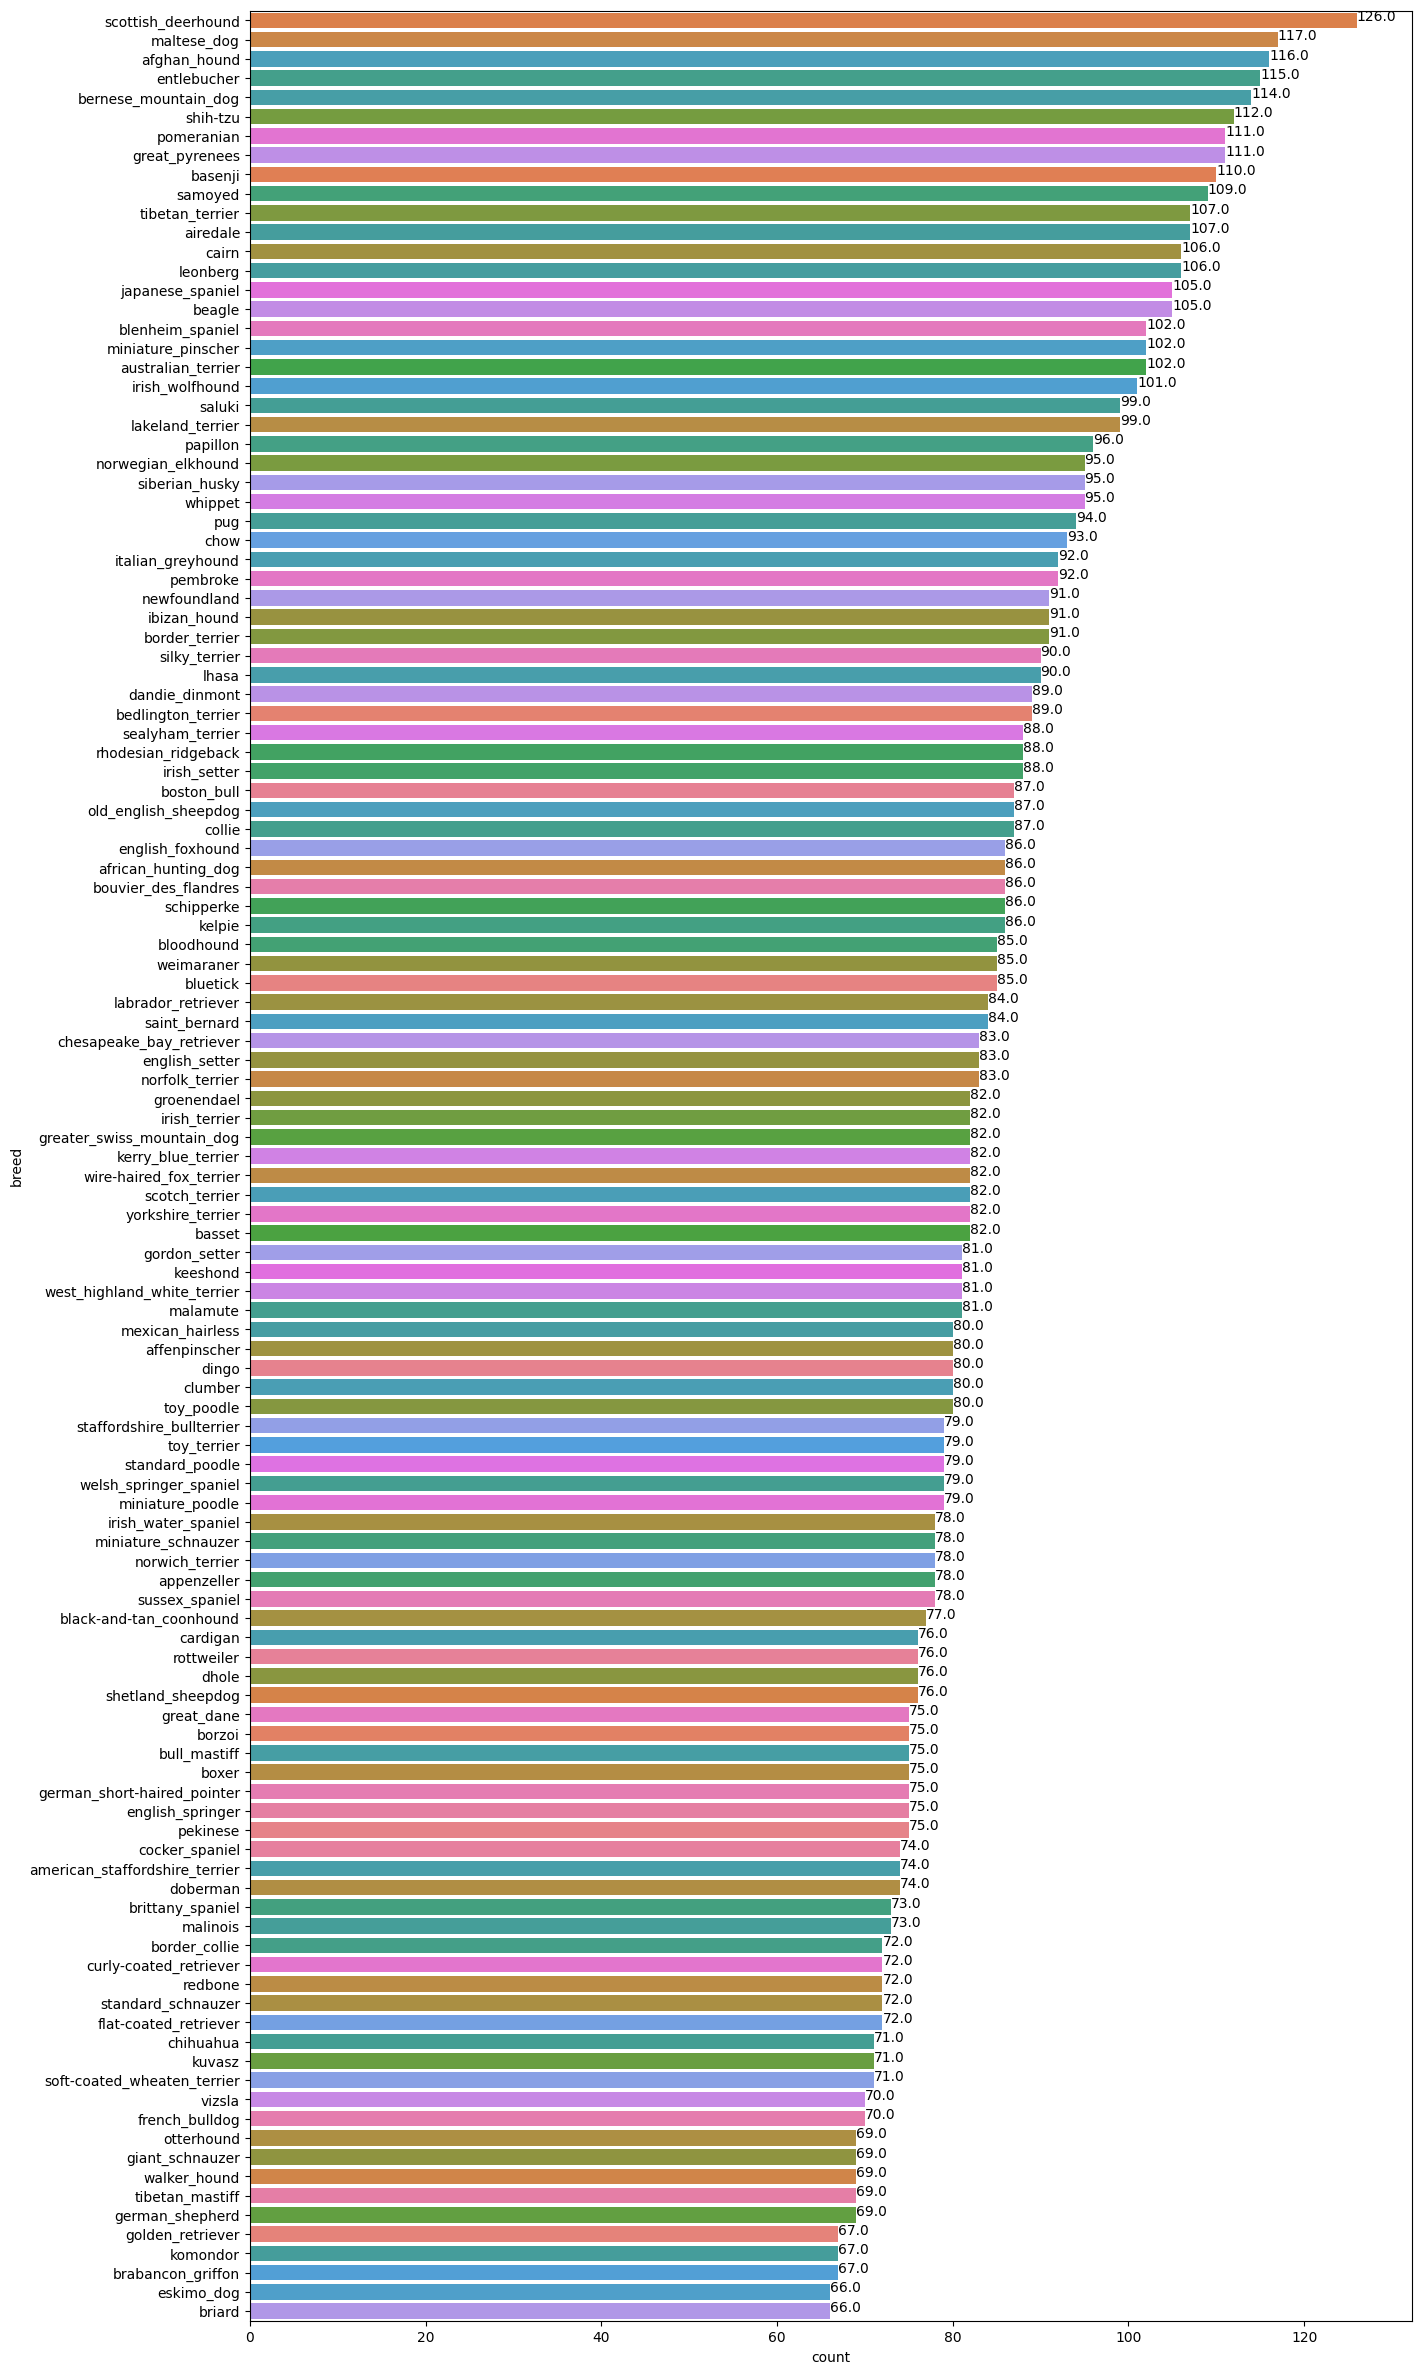

In [11]:
#function to show bar length
def barw(ax): 
    for p in ax.patches:
        val = p.get_width() #height of the bar
        x = p.get_x()+ p.get_width() # x- position 
        y = p.get_y() + p.get_height()/2 #y-position
        ax.annotate(round(val,2),(x,y))
        
#finding top dog brands
plt.figure(figsize = (15,30))
ax0 = sns.countplot(data=df, y='breed', hue='breed', order=df['breed'].value_counts().index, palette='husl', legend=False)
# 'rainbow', 'Set3', 'husl', 'Paired', 'Spectral', 'RdYlBu', 'viridis' 
barw(ax0)
plt.show()

## Randomly sample and display images from training, validation and test sets

train set size：9199
val set size  ：1023
test set size ：10357


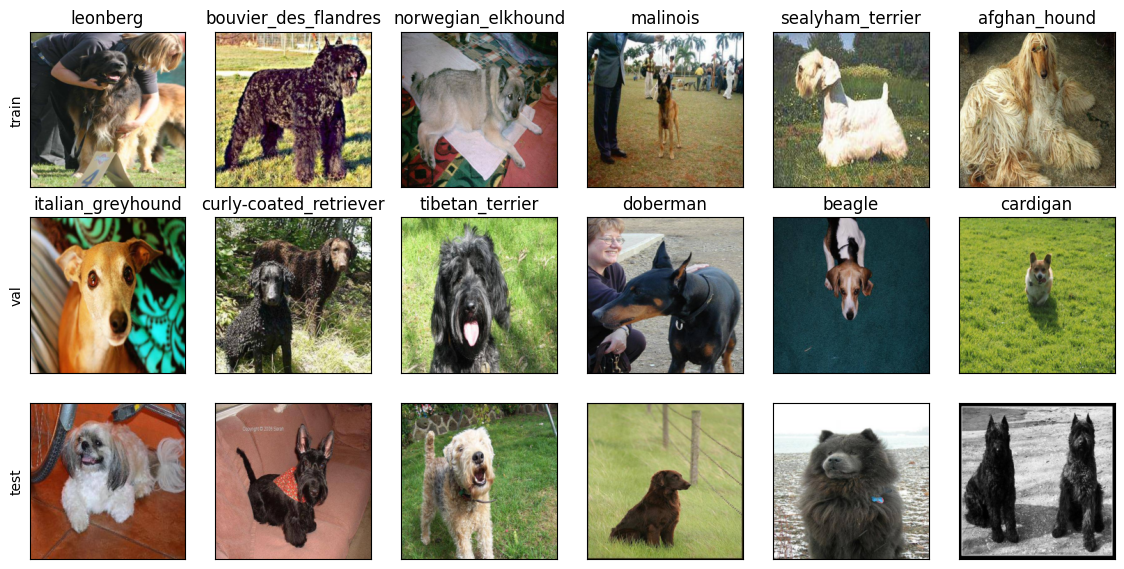

In [12]:
print(f'train set size：{len(train_set)}\nval set size  ：{len(val_set)}\ntest set size ：{len(test_set)}')

def sample_imgs_in_dataset(data, num):
    indices = random.sample(list(range(len(data))), num)
    samples = [data[i] for i in indices] # (image, label)
    return samples

s_sum = 6
image_wall = [sample_imgs_in_dataset(train_set, s_sum),
              sample_imgs_in_dataset(val_set  , s_sum),
              sample_imgs_in_dataset(test_set , s_sum)]

fig = plt.figure(figsize=(14,14.))
grid = ImageGrid(
    fig, 111,
    nrows_ncols = (3, s_sum),
    axes_pad=0.3 # pad between axes in inch.
) 
for i in range(3):
    for j in range(s_sum):
        ax = grid[i*s_sum+j] # calculate index of this image
        ax.imshow(image_wall[i][j][0]) # image_wall[i][j][0] -> image, image_wall[i][j][0] -> label
        if len(image_wall[i][j]) > 1:  # label is not None
            ax.set_title(train_set.id2label[image_wall[i][j][1].item()]) # .item()：tensor -> standard 
        if j == 0:
            ax.set_ylabel(['train', 'val', 'test'][i])
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
plt.show()

Normalization parameters

In [13]:
# Using normalization parameters pre-trained on ImageNet
norm_params = {
    'mean':[0.485, 0.456, 0.406],
    'std' :[0.229, 0.224, 0.225]
}

# Data Preprocessing for val set and test set

In [14]:
simple_tf = tf.Compose([
    tf.ToTensor(),
    tf.Resize((224,224), antialias=True),
    tf.Normalize(**norm_params) # **：unpacking operator
])

# Data Augmentation
Increase the diversity of training data to improve model generalization and robustness  
- Geometric Transformations  
- Color Transformations
- Noise Injection

In [15]:
train_tf = tf.Compose([
    tf.PILToTensor(),
    tf.ConvertImageDtype(torch.float),
    # tf.AutoAugment(tf.AutoAugmentPolicy.IMAGENET),
    tf.ColorJitter(brightness=0.1 ,contrast=0.1, saturation=0.1),
    tf.RandomChoice([
        tf.Compose([
            tf.RandomRotation(10),
            tf.RandomResizedCrop((224,224), scale=(0.8, 1.0), antialias=True)
        ]),
        tf.Compose([
            tf.RandomAffine(10, translate=(0.0, 0.05), scale=(0.9, 1.0)),
            tf.Resize((224,224), antialias=True)
        ]),
    ]),
    tf.RandomHorizontalFlip(),
    tf.Normalize(**norm_params)
])

Reinitialize Dataset

In [16]:
train_set = DogBreedDataset('/kaggle/input/dog-breed-identification/train', all_labels=dog_breeds, csv_file='train.csv', transform=train_tf)
val_set   = DogBreedDataset('/kaggle/input/dog-breed-identification/train', all_labels=dog_breeds, csv_file='val.csv', transform=simple_tf)
test_set  = DogBreedDataset('/kaggle/input/dog-breed-identification/test',  all_labels=dog_breeds, transform=simple_tf)
print(train_set.labels)
print(val_set.labels)

0             irish_setter
1          norfolk_terrier
2       bedlington_terrier
3              maltese_dog
4              appenzeller
               ...        
9194                beagle
9195       standard_poodle
9196     italian_greyhound
9197        great_pyrenees
9198    kerry_blue_terrier
Name: breed, Length: 9199, dtype: object
0                       toy_terrier
1                      irish_setter
2                scottish_deerhound
3                    english_setter
4                    great_pyrenees
                   ...             
1018    german_short-haired_pointer
1019               japanese_spaniel
1020                    toy_terrier
1021                          dingo
1022                   walker_hound
Name: breed, Length: 1023, dtype: object


Data visualization

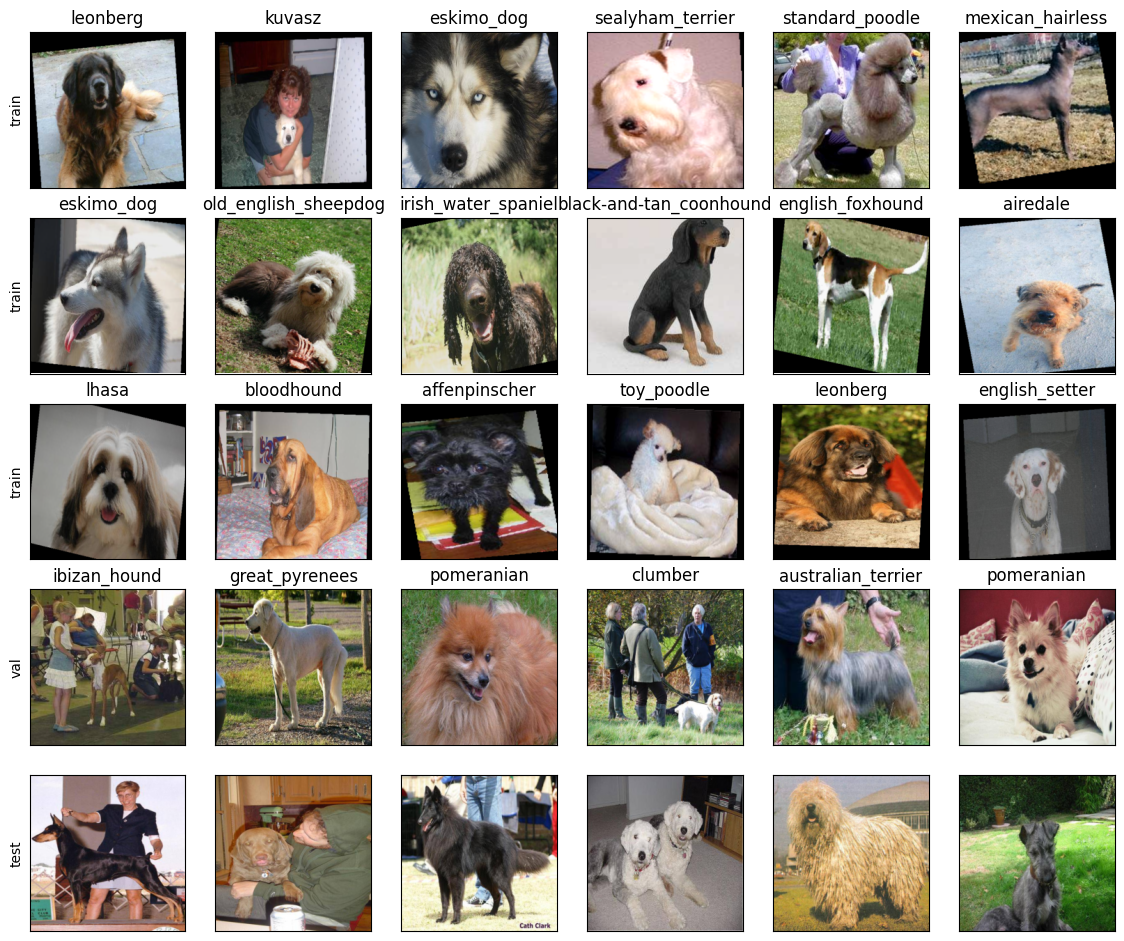

In [17]:
def unnormalize(norm_img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    for i in range(3): # R,G,B
        norm_img[i] = norm_img[i]*std[i] + mean[i]
    return norm_img

image_wall = [sample_imgs_in_dataset(train_set, s_sum),
              sample_imgs_in_dataset(train_set, s_sum),
              sample_imgs_in_dataset(train_set, s_sum),
              sample_imgs_in_dataset(val_set,   s_sum),
              sample_imgs_in_dataset(test_set,  s_sum)]

fig = plt.figure(figsize=(14,14.))
grid = ImageGrid(
    fig, 111,
    nrows_ncols=(5,s_sum),
    axes_pad = 0.3
)

for i in range(5):
    for j in range(s_sum):
        ax = grid[i*s_sum+j]
        img = image_wall[i][j][0]
        img = unnormalize(img).permute(1, 2, 0).numpy() # tensor:(C,H,W) -> matplotlib needs (H,W,C)
        ax.imshow(img)
        if len(image_wall[i][j]) > 1:
            ax.set_title(train_set.id2label[image_wall[i][j][1].item()])
        if j == 0:
            ax.set_ylabel(['train', 'train', 'train', 'val', 'test'][i])
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
plt.show()

# Build Model

Using pretrained model: Leverage models trained on large-scale datasets (e.g., ImageNet) to provide powerful feature extraction capabilities, accelerate training and improve model performance

## ConvNeXt (CVPR 2022)
A pure ConvNet model that matches or exceeds Transformers' performance by modernizing standard ConvNet architecture:
- Macro design: Changed stage compute ratio and stem cell
- ResNeXt-ify: Depthwise conv and inverted bottleneck
- Micro design: Larger kernels (7x7) and fewer activation functions
- Modern training: Layer norm and better training techniques

Key advantages:
- Simple yet effective architecture
- Strong performance comparable to Transformers
- Better efficiency and easier deployment

In [18]:
"""
ConvNeXt Small Model (convnext_small.in12k_ft_in1k):
- Architecture: ConvNeXt small variant
- Pre-training: First trained on ImageNet-12K (12,000 classes)
- Fine-tuning: Then fine-tuned on ImageNet-1K (1,000 classes)
- Model Size: Smaller than base version, balanced between efficiency and performance
"""
def build_convnext_model():
    model = timm.create_model('convnext_small.in12k_ft_in1k', pretrained=True, num_classes=120)
    return model

model = build_convnext_model()
summary(model, depth=4)

model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

Layer (type:depth-idx)                             Param #
ConvNeXt                                           --
├─Sequential: 1-1                                  --
│    └─Conv2d: 2-1                                 4,704
│    └─LayerNorm2d: 2-2                            192
├─Sequential: 1-2                                  --
│    └─ConvNeXtStage: 2-3                          --
│    │    └─Identity: 3-1                          --
│    │    └─Sequential: 3-2                        --
│    │    │    └─ConvNeXtBlock: 4-1                79,296
│    │    │    └─ConvNeXtBlock: 4-2                79,296
│    │    │    └─ConvNeXtBlock: 4-3                79,296
│    └─ConvNeXtStage: 2-4                          --
│    │    └─Sequential: 3-3                        --
│    │    │    └─LayerNorm2d: 4-4                  192
│    │    │    └─Conv2d: 4-5                       73,920
│    │    └─Sequential: 3-4                        --
│    │    │    └─ConvNeXtBlock: 4-6                306,0

Print parameter names and shapes

In [19]:
for name, param in model.named_parameters():
    print(f'{name}\t{param.shape}\t{param.requires_grad}') 

stem.0.weight	torch.Size([96, 3, 4, 4])	True
stem.0.bias	torch.Size([96])	True
stem.1.weight	torch.Size([96])	True
stem.1.bias	torch.Size([96])	True
stages.0.blocks.0.gamma	torch.Size([96])	True
stages.0.blocks.0.conv_dw.weight	torch.Size([96, 1, 7, 7])	True
stages.0.blocks.0.conv_dw.bias	torch.Size([96])	True
stages.0.blocks.0.norm.weight	torch.Size([96])	True
stages.0.blocks.0.norm.bias	torch.Size([96])	True
stages.0.blocks.0.mlp.fc1.weight	torch.Size([384, 96])	True
stages.0.blocks.0.mlp.fc1.bias	torch.Size([384])	True
stages.0.blocks.0.mlp.fc2.weight	torch.Size([96, 384])	True
stages.0.blocks.0.mlp.fc2.bias	torch.Size([96])	True
stages.0.blocks.1.gamma	torch.Size([96])	True
stages.0.blocks.1.conv_dw.weight	torch.Size([96, 1, 7, 7])	True
stages.0.blocks.1.conv_dw.bias	torch.Size([96])	True
stages.0.blocks.1.norm.weight	torch.Size([96])	True
stages.0.blocks.1.norm.bias	torch.Size([96])	True
stages.0.blocks.1.mlp.fc1.weight	torch.Size([384, 96])	True
stages.0.blocks.1.mlp.fc1.bias	tor

Freeze partial parameters during fine-tuning, only train the deeper layers

In [20]:
def freeze_backbone(model):
    for name, param in model.named_parameters():
        if name.startswith('head'):
            param.requires_grad = True
        elif name.startswith('stages.3.'):
            param.requires_grad = True
        elif name.startswith('stages.2.blocks.2'):
            param.requires_grad = True
        else:
            param.requires_grad = False

### Training Configuration

Get parameters that should not apply weight decay

In [21]:
"""
- Normalization layer parameters (.norm.)
- Bias parameters (.bias)
"""
def _get_no_decay_params(model):
    no_decay_params = []
    for name, param in model.named_parameters():
        if ".norm." in name:
            no_decay_params.append(param)
        elif name.endswith('.bias'):
            no_decay_params.append(param)
    return set(no_decay_params)

Optimizer Configuration

In [22]:
def get_optim(pt_model, lr, weight_decay, lr_decay):
    param_groups = []
    no_decay_params = _get_no_decay_params(pt_model)
    for name, param in pt_model.named_parameters():
        if param.requires_grad is True:
            if name.startswith('stages.3.'):
                scale = lr_decay
            elif name.startswith('stages.2.'):
                scale = lr_decay ** 2
            else:
                scale = 1.0
            param_group = {'params':param, 'lr':lr * scale}
            if name not in no_decay_params:
                param_group['weight_decay'] = weight_decay
            
            param_groups.append(param_group)
    optimizer = torch.optim.AdamW(param_groups, lr=lr)
    return optimizer

Configure Learning Rate Scheduler

In [23]:
def get_scheduler(optim, num_warmup_steps, num_training_steps):
    return transformers.get_linear_schedule_with_warmup(optim, num_warmup_steps, num_training_steps)

**Model Training Function**  

Description：
- Train and validate the model with logging functionality.  

Parameters：
- model：Neural network model  
- dataloaders：Tuple of (train_loader, val_loader)  
- optimizer：Model optimizer  
- scheduler：Learning rate scheduler  
- **kwargs：Additional parameters including：
    - device：Training device (CPU/GPU)  
    - max_epochs：Maximum training epochs  
    - steps_per_epoch：Steps per epoch  

Logging Metrics：
- Training：
    - Loss  
    - Average Precision (AP)  
    - Accuracy  
- Validation：
    - Loss  
    - Average Precision (AP)  
    - Accuracy  
- Other：
    - Learning rate  

Process：
- Training phase：
    - Forward pass  
    - Loss calculation  
    - Backward pass  
    - Optimizer and scheduler steps  
    - Metrics update  
    
- Validation phase：  
    - Model evaluation  
    - Metrics calculation  
    - Performance logging  

Returns：  
- logger：Dictionary containing training and validation metrics

In [24]:
def train(model, dataloaders, optimizer, scheduler, **kwargs):
    # logger
    logger = {
        'train/loss':[],
        'train/ap':[],
        'train/acc':[],
        'val/loss':[],
        'val/ap':[],
        'val/acc':[],
        'lr':[]
    }
    
    train_loader, val_loader = dataloaders # DataLoader(dataset, batch_size, shuffle, num_workers, pin_memory, drop_last...)
    device = kwargs['device']
    loss = nn.CrossEntropyLoss().to(device)
    model = model.to(device)
    
    for epoch in range(kwargs['max_epochs']):
        # Training
        loss_list = []
        model.train()
        ap_metric = MulticlassAUPRC(num_classes=120) # Average Precision
        acc_metric = MulticlassAccuracy(num_classes=120) # Accuracy
        last_time = time.time()
        for local_step, (img,label) in enumerate(train_loader): # local_step start from 0, automatically +1 
            step = epoch * kwargs['steps_per_epoch'] + local_step # local_step：num of batch，step：total step
            img, label = img.to(device), label.to(device)
            
            optimizer.zero_grad()
            logits = model(img)
            l = loss(logits, label)
            ap_metric.update(logits, label)
            acc_metric.update(logits, label)
            l.backward()
            optimizer.step() # update parameters
            scheduler.step() 
    
            # log 
            loss_list.append(l.detach().cpu().item())
            logger['train/loss'].append(l.detach().cpu().item())
            logger['lr'].append(optimizer.state_dict()['param_groups'][0]['lr'])
            if (local_step % 5 == 0 and local_step != 0) or local_step == kwargs['steps_per_epoch'] - 1:
                print('Epoch {}/{} | Step {}/{} | loss: {:.5f} Accuracy: {:.4f} AP: {:.4f} time: {:.1f}s'.format(
                    epoch, kwargs['max_epochs'],
                    local_step, kwargs['steps_per_epoch'],
                    sum(loss_list)/len(loss_list),
                    acc_metric.compute().cpu().item(),
                    ap_metric.compute().cpu().item(),
                    time.time()-last_time
                ))
                last_time = time.time()
        logger['train/acc'].append(acc_metric.compute().cpu().item())
        logger['train/ap'].append(ap_metric.compute().cpu().item())
        
        # Validation
        if True:
            loss_list = []
            ap_metric = MulticlassAUPRC(num_classes=120)
            acc_metric = MulticlassAccuracy(num_classes=120)
            print('-'*20 + '  Validating  '+'-'*20)
            model.eval()
            with torch.no_grad():
                for local_step, (img,label) in enumerate(val_loader):
                    img, label = img.to(device), label.to(device)
                    logits = model(img)
                    l = loss(logits, label)
                    ap_metric.update(logits, label)
                    acc_metric.update(logits, label)
                    loss_list.append(l.cpu().item())
                    
                avg_val_loss = sum(loss_list)/len(loss_list)
                
                # log
                logger['val/acc'].append(acc_metric.compute().cpu().item())
                logger['val/ap'].append(ap_metric.compute().cpu().item())
                logger['val/loss'].append(avg_val_loss)
                print('Epoch {}/{} | loss:{:.5f} Accuracy:{:.4f} AP:{:.4f}'.format(
                    epoch, kwargs['max_epochs'],
                    avg_val_loss,
                    acc_metric.compute().cpu().item(),
                    ap_metric.compute().cpu().item()
                ))
        print('='*53)
    return logger

Hyperparameter Settings

In [25]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_epochs = 30
lr = 1e-5
weight_decay = 0.01
num_warmup_steps = 0.5*math.ceil(len(train_set)/batch_size)
num_training_steps = max_epochs * math.ceil(len(train_set)/batch_size)
lr_decay = 0.1

### Start training

In [26]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False)
model = build_convnext_model()
optimizer = get_optim(model, lr, weight_decay, lr_decay=lr_decay)
scheduler = get_scheduler(optimizer, num_warmup_steps, num_training_steps)
freeze_backbone(model)

print(summary(model, depth=2))

logger = train(
    model, (train_dataloader, val_dataloader), optimizer, scheduler,
    device = device,
    max_epochs = max_epochs,
    steps_per_epoch = len(train_dataloader)
)

Layer (type:depth-idx)                             Param #
ConvNeXt                                           --
├─Sequential: 1-1                                  --
│    └─Conv2d: 2-1                                 (4,704)
│    └─LayerNorm2d: 2-2                            (192)
├─Sequential: 1-2                                  --
│    └─ConvNeXtStage: 2-3                          (237,888)
│    └─ConvNeXtStage: 2-4                          (992,256)
│    └─ConvNeXtStage: 2-5                          32,747,520
│    └─ConvNeXtStage: 2-6                          15,470,592
├─Identity: 1-3                                    --
├─NormMlpClassifierHead: 1-4                       --
│    └─SelectAdaptivePool2d: 2-7                   --
│    └─LayerNorm2d: 2-8                            1,536
│    └─Flatten: 2-9                                --
│    └─Identity: 2-10                              --
│    └─Dropout: 2-11                               --
│    └─Linear: 2-12                 

In [27]:
print(torch.__version__)
print(torch.version.cuda)
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name()}")

2.5.1+cu121
12.1
Current device: 0
Device name: Tesla P100-PCIE-16GB


### Save Model

In [28]:
torch.save(model.state_dict(), 'convnext_model.pth')
from IPython.display import FileLink
FileLink(r'convnext_model.pth')

/kaggle/working/convnext_model.pth

### Visualize Training Logs

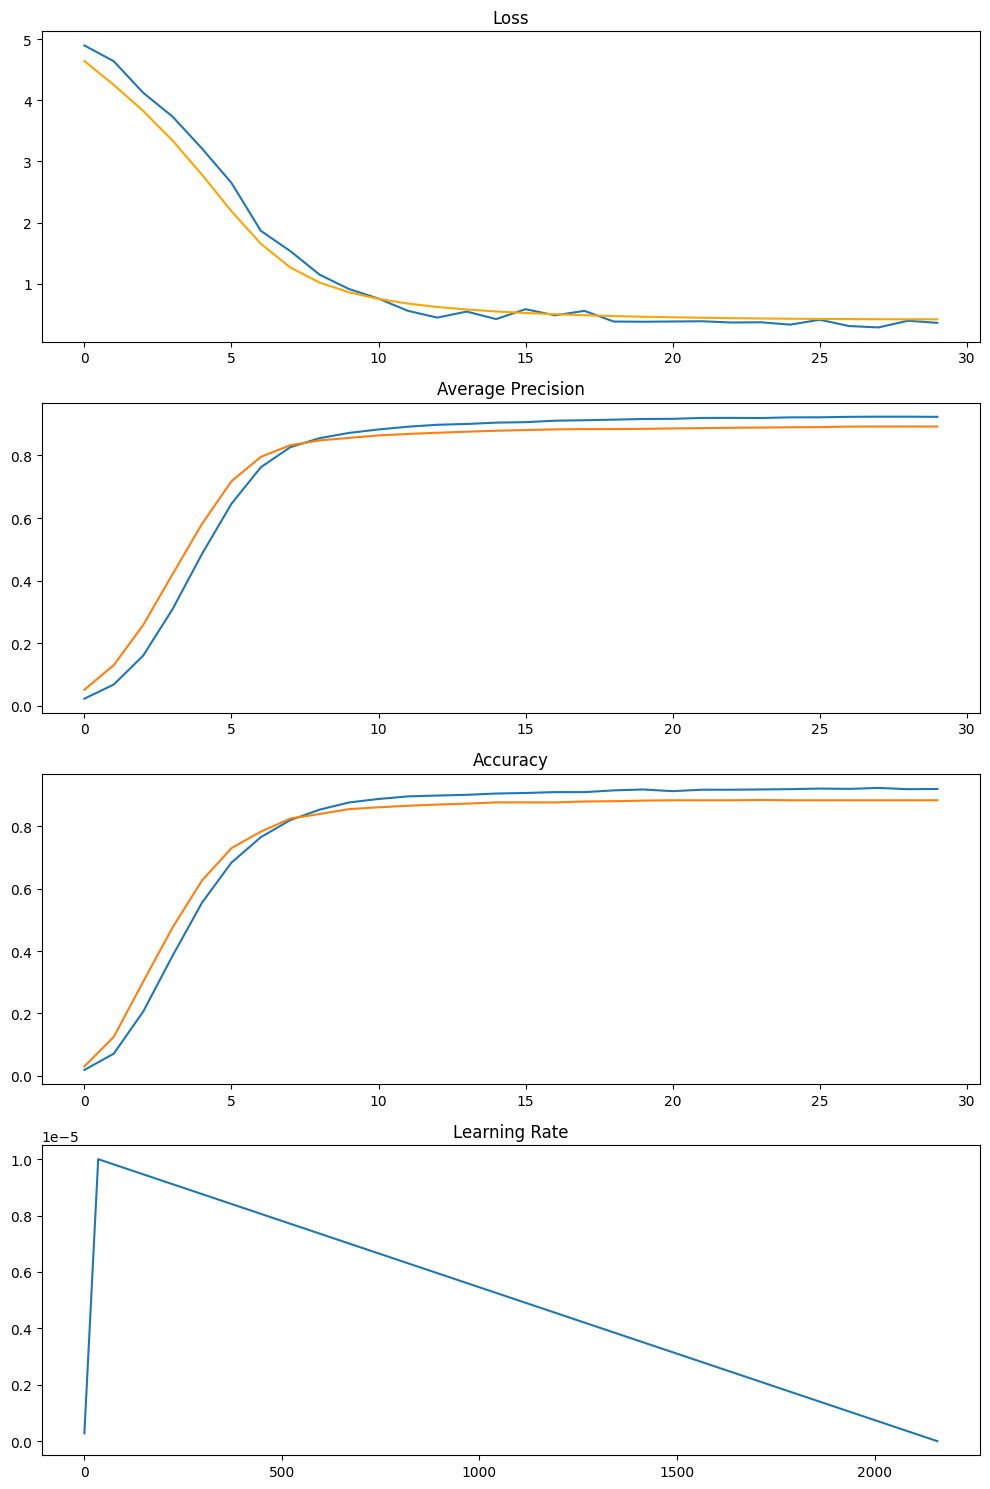

In [29]:
fig, axs = plt.subplots(4, 1, figsize=(10,15))

train_steps = len(logger['train/loss'])
val_steps = len(logger['val/loss'])
train_indices = np.linspace(0, train_steps-1, val_steps, dtype=int)

sns.lineplot(
    x = range(val_steps),
    y = [logger['train/loss'][i] for i in train_indices], 
    ax = axs[0]
)
sns.lineplot(
    x = range(val_steps),
    y = logger['val/loss'],
    ax = axs[0],
    color = 'orange'
)
axs[0].set_title('Loss')

sns.lineplot(
    x = range(len(logger['train/ap'])),
    y = logger['train/ap'],
    ax = axs[1]
)
sns.lineplot(
    x = range(len(logger['val/ap'])),
    y = logger['val/ap'],
    ax = axs[1]
)
axs[1].set_title('Average Precision')

sns.lineplot(
    x = range(len(logger['train/acc'])),
    y = logger['train/acc'],
    ax = axs[2]
)
sns.lineplot(
    x = range(len(logger['val/acc'])),
    y = logger['val/acc'],
    ax = axs[2]
)
axs[2].set_title('Accuracy')

sns.lineplot(
    x = range(len(logger['lr'])),
    y = logger['lr'],
    ax = axs[3]
)
axs[3].set_title('Learning Rate')

plt.tight_layout()
plt.show()

### Examine Recognition Performance by Class
Validation

In [32]:
import warnings
warnings.filterwarnings("ignore", message="The reduce argument of torch.scatter*")
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
ap_metric = MulticlassAUPRC(num_classes=120, average=None).to(device)
acc_metric = MulticlassAccuracy(num_classes=120, average=None).to(device)
print('-'*20 + '  validation  ' + '-'*20)
model.eval()
with torch.no_grad():
    for x, y in tqdm(val_dataloader):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        ap_metric.update(logits, y)
        acc_metric.update(logits, y)
ap = [round(i, 4) for i in ap_metric.compute().cpu().tolist()]
acc = [round(i, 4) for i in acc_metric.compute().cpu().tolist()]
print(f'AP：{ap}')
print(f'ACC：{acc}')

--------------------  validation  --------------------


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


AP：[1.0, 1.0, 0.9924, 0.8544, 0.385, 0.5919, 0.819, 1.0, 1.0, 0.8171, 1.0, 0.9922, 0.8768, 0.975, 1.0, 0.9769, 0.769, 1.0, 1.0, 1.0, 0.7685, 0.9365, 0.9375, 0.7644, 0.809, 0.9861, 1.0, 0.9861, 1.0, 0.9762, 1.0, 0.9924, 0.9909, 0.5559, 0.986, 0.9667, 0.9535, 1.0, 1.0, 0.7088, 1.0, 0.9267, 0.9534, 0.3552, 0.8894, 1.0, 0.9683, 1.0, 0.9116, 0.9762, 1.0, 0.895, 0.9931, 0.835, 1.0, 1.0, 1.0, 0.9294, 0.9821, 0.6164, 0.7517, 0.981, 1.0, 0.8785, 0.9617, 1.0, 0.8333, 0.9478, 0.888, 1.0, 0.6555, 0.9381, 1.0, 0.8968, 1.0, 0.9945, 0.7539, 0.5, 0.9762, 0.8809, 1.0, 0.6938, 1.0, 1.0, 1.0, 0.7813, 0.8494, 1.0, 0.75, 0.9821, 0.9094, 1.0, 1.0, 0.9833, 0.9659, 0.9442, 0.7708, 0.9532, 1.0, 0.8833, 0.9761, 0.7065, 0.4623, 0.8378, 0.6218, 0.8906, 0.4798, 1.0, 0.7618, 0.6766, 0.7979, 0.7735, 0.9792, 0.8808, 1.0, 1.0, 0.9762, 0.9153, 0.7051, 0.7267]
ACC：[1.0, 1.0, 1.0, 1.0, 0.6, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 0.9333, 0.8333, 0.9333, 0.8, 0.9, 0.8889, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.5, 0.8, 1.0, 0.9, 0.75, 1.0

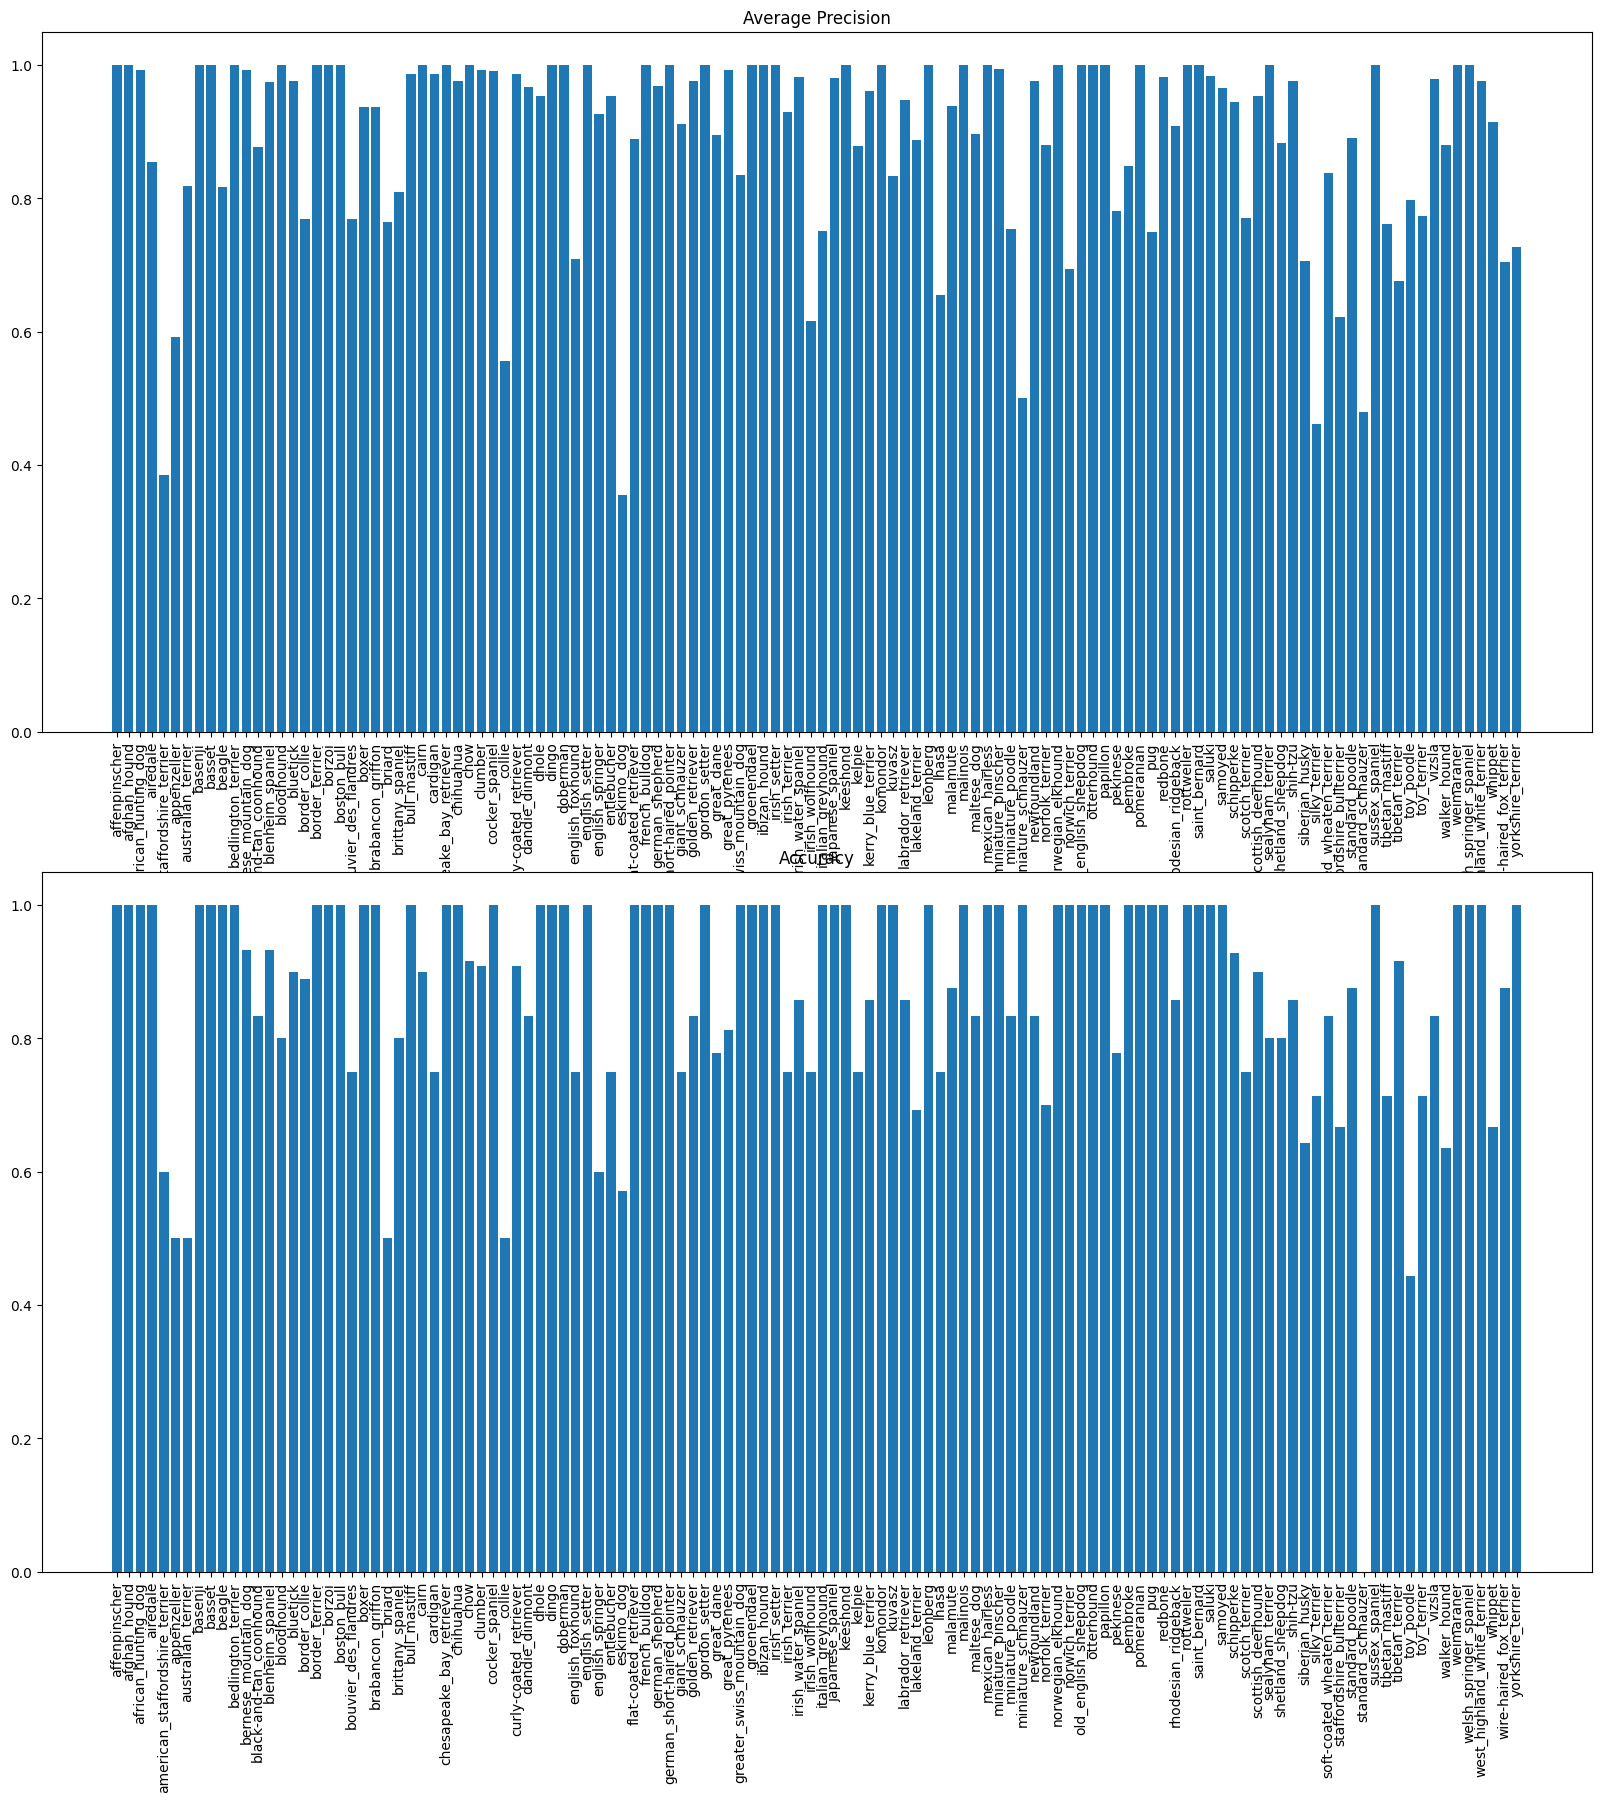

In [33]:
plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.bar(test_set.id2label.values(), ap)
plt.xticks(rotation = 90)
plt.title('Average Precision')
plt.subplot(2,1,2)
plt.bar(test_set.id2label.values(), acc)
plt.xticks(rotation = 90)
plt.title('Accuracy')
plt.show()

### Generate Submission File

In [34]:
test_dataloader = DataLoader(test_set, batch_size = batch_size, shuffle=False)
print('-'*20 + '  test  ' + '-'*20)
model.eval()
all_probs = []
with torch.no_grad():
    for x in tqdm(test_dataloader):
        x = x[0].to(device)
        probs = torch.softmax(model(x), dim = -1)
        all_probs.append(probs)
all_probs = torch.cat(all_probs, dim = 0)

--------------------  test  --------------------


100%|██████████| 81/81 [02:26<00:00,  1.80s/it]


In [35]:
with open('submission.csv', 'w+') as f:
    f.write('id,' + ','.join(test_set.id2label.values()) + '\n')
    for path, prob in zip(test_set.img_paths, all_probs):
        f.write(path.stem + ',' + ','.join([str(i) for i in prob.tolist()]) + '\n')

In [36]:
FileLink('submission.csv')

/kaggle/working/submission.csv